**Task 2: News Category Classification**

# Import Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from collections import Counter

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Download The Dataset

In [2]:
import kagglehub

path = kagglehub.dataset_download("amananandrai/ag-news-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ag-news-classification-dataset


In [3]:
dataset_path = "/kaggle/input/ag-news-classification-dataset"

print("Files in dataset folder:", os.listdir(dataset_path))

Files in dataset folder: ['train.csv', 'test.csv']


In [4]:
train_df = pd.read_csv(os.path.join(dataset_path, "train.csv"), header=None, skiprows=1)
test_df = pd.read_csv(os.path.join(dataset_path, "test.csv"), header=None, skiprows=1)

cols = ["label", "title", "description"]
train_df.columns = cols
test_df.columns = cols

In [5]:
train_df.head(3)

,label,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...


In [6]:
test_df.head(3)

,label,title,description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...


In [7]:
print(train_df["label"].unique())
print(test_df["label"].unique())

[3 4 2 1]
[3 4 2 1]


In [8]:
label_map = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tech"}
train_df["category"] = train_df["label"].map(label_map)
test_df["category"] = test_df["label"].map(label_map)

In [9]:
train_df.head(3)

,label,title,description,category
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Business
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Business


In [10]:
test_df.head(3)

,label,title,description,category
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,Business
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...",Sci/Tech
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,Sci/Tech


# Preprocess The Data

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
  text = text.lower() # lowercasing
  text = re.sub(r'[^a-z\s]', '', text) # remove special characters, numbers, and punctuation
  tokens = [word for word in text.split() if word not in stop_words] # tokenize and remove stopwords
  tokens = tokens = [lemmatizer.lemmatize(word) for word in tokens] # lemmatize
  return ' '.join(tokens)

train_df["clean_text"] = (train_df["title"] + " " + train_df["description"]).apply(preprocess)
test_df["clean_text"] = (test_df["title"] + " " + test_df["description"]).apply(preprocess)

In [12]:
train_df.head(1)

,label,title,description,category,clean_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Business,wall st bear claw back black reuters reuters s...


In [13]:
test_df.head(1)

,label,title,description,category,clean_text
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,Business,fear n pension talk union representing worker ...


# Vectorization TF-IDF

In [14]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

y_train = train_df["label"]
y_test = test_df["label"]

# Logistic Regression

In [15]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

# Evaluation

In [16]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred)*100)
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_map.values()))

Accuracy: 91.71052631578948

Classification Report:

              precision    recall  f1-score   support

       World       0.93      0.91      0.92      1900
      Sports       0.95      0.98      0.97      1900
    Business       0.89      0.88      0.89      1900
    Sci/Tech       0.89      0.90      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



# Word Clouds Per Category

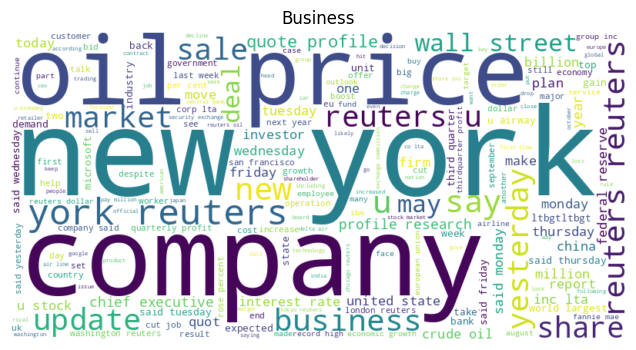

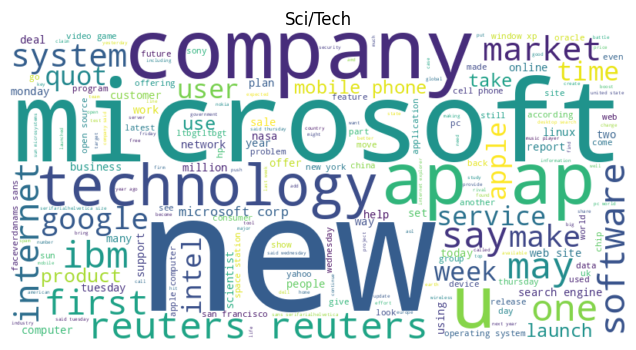

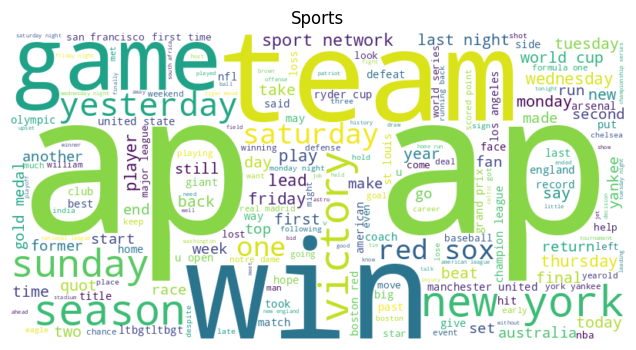

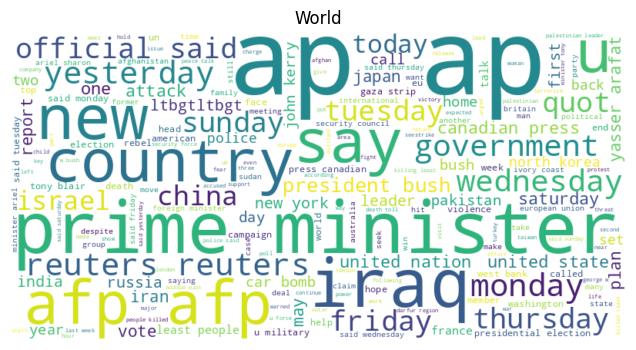

In [17]:
for cat in train_df["category"].unique():
    text = " ".join(train_df[train_df["category"] == cat]["clean_text"])
    wc = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(cat)
    plt.show()

# Inference

In [18]:
# inference function
def predict_category(title, description):
  # combine title and description
  text = title + " " + description

  # preprocess
  clean_text = preprocess(text)

   # vectorize
  X_input = vectorizer.transform([clean_text])

  # predict
  pred_label = model.predict(X_input)[0]
  pred_category = label_map[pred_label]

  return pred_category

In [19]:
# samples
samples = [
    # sports
    ("Liverpool wins dramatic Champions League final",
     "The English club secured victory after a tense penalty shootout against Barcelona."),

    # business
    ("Tesla announces record quarterly profits",
     "The electric car maker reported higher than expected earnings driven by strong vehicle sales."),

    # world
    ("UN holds emergency meeting on global climate crisis",
     "Leaders from over 50 nations gathered to discuss urgent measures to address rising global temperatures."),

    # sci/tech
    ("NASA reveals plan for new lunar mission",
     "The mission aims to establish a permanent human base on the moon by 2035.")
]

for title, desc in samples:
    prediction = predict_category(title, desc)
    print(f"Title: {title}\nPrediction: {prediction}\n{'-'*60}")

Title: Liverpool wins dramatic Champions League final
Prediction: Sports
------------------------------------------------------------
Title: Tesla announces record quarterly profits
Prediction: Business
------------------------------------------------------------
Title: UN holds emergency meeting on global climate crisis
Prediction: World
------------------------------------------------------------
Title: NASA reveals plan for new lunar mission
Prediction: Sci/Tech
------------------------------------------------------------


In [20]:
# tricky samples
tricky_samples = [
    # sports + business
    ("Nike signs record sponsorship deal with top football club",
     "The partnership is expected to boost both brand visibility and team revenues."),

    # business + tech
    ("Google invests $1 billion in renewable energy projects",
     "The company aims to reduce carbon emissions while creating new revenue opportunities."),

    # politics/world
    ("President signs historic trade agreement with European nations",
     "The deal is expected to strengthen diplomatic ties and increase exports.")
]

for title, desc in tricky_samples:
    prediction = predict_category(title, desc)
    print(f"Title: {title}\nPrediction: {prediction}\n{'-'*60}")

Title: Nike signs record sponsorship deal with top football club
Prediction: Sports
------------------------------------------------------------
Title: Google invests $1 billion in renewable energy projects
Prediction: Sci/Tech
------------------------------------------------------------
Title: President signs historic trade agreement with European nations
Prediction: World
------------------------------------------------------------


# Simple Feedforward Neural Network

In [21]:
# convert labels to 0-based indexing
train_df["label"] = train_df["label"] - 1
test_df["label"] = test_df["label"] - 1

print(train_df["label"].unique())

[2 3 1 0]


In [22]:
y_train = train_df["label"].values
y_test = test_df["label"].values

In [23]:
# vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words="english")

X_train_vec = vectorizer.fit_transform(train_df["clean_text"]).toarray()
X_test_vec = vectorizer.transform(test_df["clean_text"]).toarray()

print(X_train_vec.shape, X_test_vec.shape)

(120000, 5000) (7600, 5000)


In [24]:
print("X_train_vec:", X_train_vec.shape)
print("y_train:", y_train.shape)
print("X_test_vec:", X_test_vec.shape)
print("y_test:", y_test.shape)

X_train_vec: (120000, 5000)
y_train: (120000,)
X_test_vec: (7600, 5000)
y_test: (7600,)


In [25]:
# FeedForward NN
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

num_classes = 4
input_dim = X_train_vec.shape[1]

model_nn = Sequential([
    Dense(256, activation="relu", input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

model_nn.compile(optimizer="adam",
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

model_nn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     1,280,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313,668 (5.01 MB)

 Trainable params: 1,313,668 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# train the model
history = model_nn.fit(
    X_train_vec, y_train,
    validation_data=(X_test_vec, y_test),
    epochs=5,
    batch_size=32
)

Epoch 1/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - accuracy: 0.8631 - loss: 0.4085 - val_accuracy: 0.9100 - val_loss: 0.2691
Epoch 2/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 79s 15ms/step - accuracy: 0.9280 - loss: 0.2094 - val_accuracy: 0.9136 - val_loss: 0.2609
Epoch 3/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 58s 15ms/step - accuracy: 0.9441 - loss: 0.1623 - val_accuracy: 0.9157 - val_loss: 0.2709
Epoch 4/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 59s 16ms/step - accuracy: 0.9592 - loss: 0.1161 - val_accuracy: 0.9153 - val_loss: 0.3015
Epoch 5/5
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 88s 17ms/step - accuracy: 0.9721 - loss: 0.0792 - val_accuracy: 0.9118 - val_loss: 0.3500


In [27]:
# example
examples = [
    "Tesla unveils new electric truck with 600-mile range",
    "Barcelona wins Champions League final after penalty shootout",
    "United Nations holds summit on global climate change",
    "Amazon launches grocery delivery service in Europe"
]

# show predictions (probabilities) for each category
def predict_category_nn(text):
    vec = vectorizer.transform([text]).toarray()
    pred = model_nn.predict(vec, verbose=0)
    probs = pred[0]
    return probs

for ex in examples:
    probs = predict_category_nn(ex)
    print(f"Title: {ex}")
    for i, label in label_map.items():
        print(f"  {label}: {probs[i-1]:.4f}")
    print("Predicted:", label_map[probs.argmax() + 1])
    print("-" * 60)

Title: Tesla unveils new electric truck with 600-mile range
  World: 0.0405
  Sports: 0.0000
  Business: 0.9156
  Sci/Tech: 0.0439
Predicted: Business
------------------------------------------------------------
Title: Barcelona wins Champions League final after penalty shootout
  World: 0.0008
  Sports: 0.9991
  Business: 0.0000
  Sci/Tech: 0.0000
Predicted: Sports
------------------------------------------------------------
Title: United Nations holds summit on global climate change
  World: 0.6555
  Sports: 0.0000
  Business: 0.0271
  Sci/Tech: 0.3173
Predicted: World
------------------------------------------------------------
Title: Amazon launches grocery delivery service in Europe
  World: 0.0670
  Sports: 0.0000
  Business: 0.2138
  Sci/Tech: 0.7192
Predicted: Sci/Tech
------------------------------------------------------------
